In [7]:
import numpy as np
import pennylane as qml
import torch
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from data import harmonic_oscillator_solution
from lossfn import boundary_loss, physics_loss, mse
from model import Pure_QN
from train import train
from utils import draw_circuit

In [8]:
torch.manual_seed(123)

n_qubits = 4

rotation = 'Ry'
n_qubits_input = 1
n_process_layers = 20
n_qubits_output = 1

### Define wires
wires = list(range(n_qubits))
input_wires = list(range(n_qubits_input))
output_wires = list(range(n_qubits_output))

device = qml.device('default.qubit.torch', wires = n_qubits)# default.qubit lightning.qubit lightning.gpu
torch_device = "cpu"

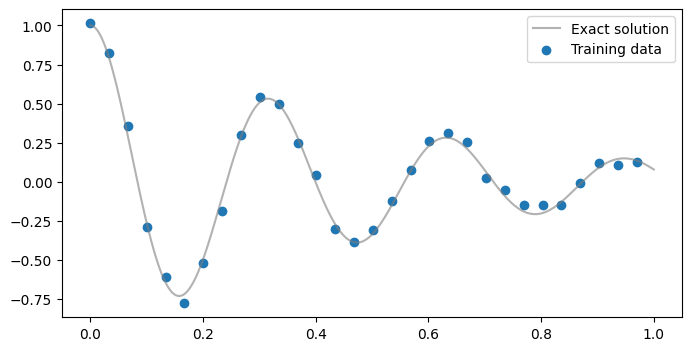

In [9]:
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'][::10].values).view(-1,1)
obs_data = torch.tensor(data['observation'][::10].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true.view(-1,1), color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

In [10]:
qmodel = Pure_QN(
    device,
    n_qubits,
    input_wires,
    n_process_layers,
    output_wires,
    rotation,
    )

In [11]:
t_initial = torch.tensor(0.).view(-1,1).requires_grad_(True)

t_data = t_data.requires_grad_(True)

d = 2
w0 = 20
mu = 2*d
k = w0**2

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True)) # mu is missing, let's train it!
all_mus = []

learning_rate=1e-3
optimiser = torch.optim.Adam(list(qmodel.parameters()) + [mu], lr=learning_rate)

lambda1, lambda2 = 1e-1, 1e-5

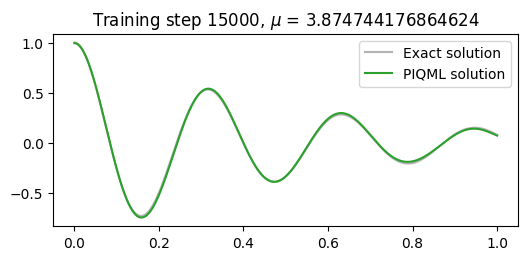

In [12]:
for i in range(15001):
    optimiser.zero_grad()

    # Loss function for initial conditions
    prediction = qmodel(t_initial)
    loss1, loss2 = boundary_loss(prediction, t_boundary=t_initial)

    # Physics loss with DE
    prediction = qmodel(t_data)
    loss3 = physics_loss(prediction, t_physics=t_data, mu=mu, k=k)

    # Combine loss
    loss:torch.Tensor = loss1 + lambda1*loss2 + lambda2*loss3 + mse(prediction, obs_data)

    # loss:torch.Tensor = lambda2*loss3 + mse(prediction, obs_data)

    loss.backward()

    optimiser.step()

    all_mus.append(mu.item())

    if i % 1 == 0: 
        clear_output(wait=True)
        prediction = qmodel(t_true).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(t_true[:,0], obs_true[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_true[:,0], prediction[:,0], label="PIQML solution", color="tab:green")
        plt.title(f"Training step {i}, $\mu$ = {mu.item()}")
        plt.legend()
        plt.show()


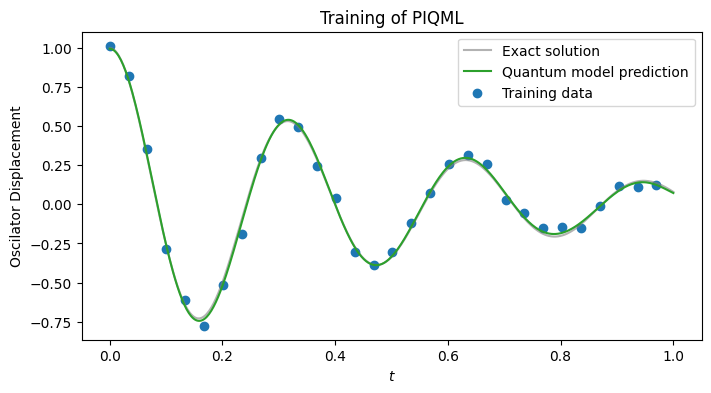

In [13]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Quantum model prediction")
    plt.scatter(x_data, y_data, label='Training data')
    plt.ylabel('Oscilator Displacement')
    plt.xlabel('$t$')
    l = plt.legend(loc='best')

plot_result(
    t_true.detach(),
    obs_true.detach(),
    t_data.detach(),
    obs_data.detach(),
    prediction,
    title='Training of PIQML'
    )

mu = Parameter containing:
tensor([3.8747], requires_grad=True)


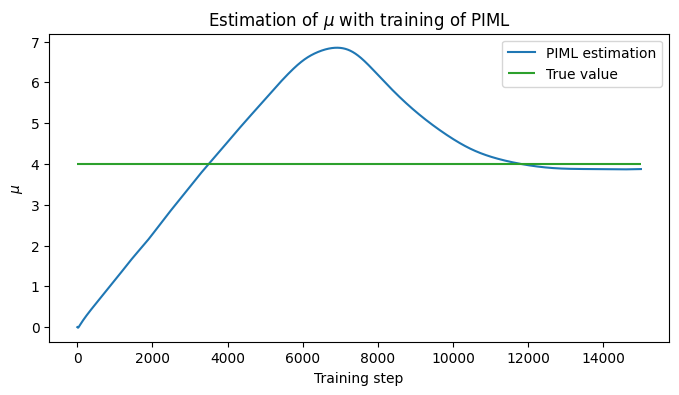

In [14]:
print(f'mu = {mu}')

plt.figure(figsize=(8,4))
plt.title("Estimation of $\mu$ with training of PIML")
plt.plot(all_mus, label="PIML estimation")
plt.hlines(2*d, 0, len(all_mus), label="True value", color="tab:green")
plt.legend(loc='best')
plt.xlabel("Training step")
plt.ylabel("$\mu$")
plt.show()